## Testing code
- Make sure your are in the right directory ending with 'UNET' - the folder this file is in
- if not, use %cd and !ls to navigate

### Testing import

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from model_unet import UNet
import torchvision.transforms as T

In [2]:
END_WITH_LOCAL = 'UNET'

os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"

NOTEBOOK_DIR = os.getcwd()
print(f"NOTEBOOK_DIR: {NOTEBOOK_DIR}")

# Simple validation
if not (NOTEBOOK_DIR.endswith('/content') or NOTEBOOK_DIR.endswith(END_WITH_LOCAL)):
    raise ValueError(f"Expected to be in .../{END_WITH_LOCAL} or .../content directory, but got: {NOTEBOOK_DIR}")

BASE_DIR = os.path.join(NOTEBOOK_DIR, '..', '..', '..')
os.listdir(BASE_DIR)

NOTEBOOK_DIR: /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/code/bubble-detection/UNET


['.DS_Store',
 'Dockerfile',
 'environments',
 'output',
 'code',
 'models',
 'README.md',
 '.dockerignore',
 '.gitignore',
 '.git',
 '.vscode',
 'data']

In [5]:
NUM_EPOCHS = 3
BATCH_SIZE = 2

IMAGE_DIR = os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images')
MASK_DIR  = os.path.join(BASE_DIR, 'data/MangaSegmentation/jsons_processed')
UNET_DATA_DIR = os.path.join(BASE_DIR, 'data/MangaSegmentation/UNET_data')
os.makedirs(UNET_DATA_DIR, exist_ok=True)
TRAIN_JSON_FILE = os.path.join(UNET_DATA_DIR, "train.json")
VAL_JSON_FILE = os.path.join(UNET_DATA_DIR, "val.json")
UNET_MODEL_DIR = os.path.join(BASE_DIR, 'models/bubble-detection/UNET')
os.makedirs(UNET_MODEL_DIR, exist_ok=True)
UNET_MODEL_FILE = os.path.join(UNET_MODEL_DIR, 'best_unet_model.pth')
EX_JSON_FILE= os.path.join(BASE_DIR,'data/MangaSegmentation/jsons_processed/Arisa.json')
EX_IMG_FILE= os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images/AisazuNihaIrarenai/045.jpg')

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


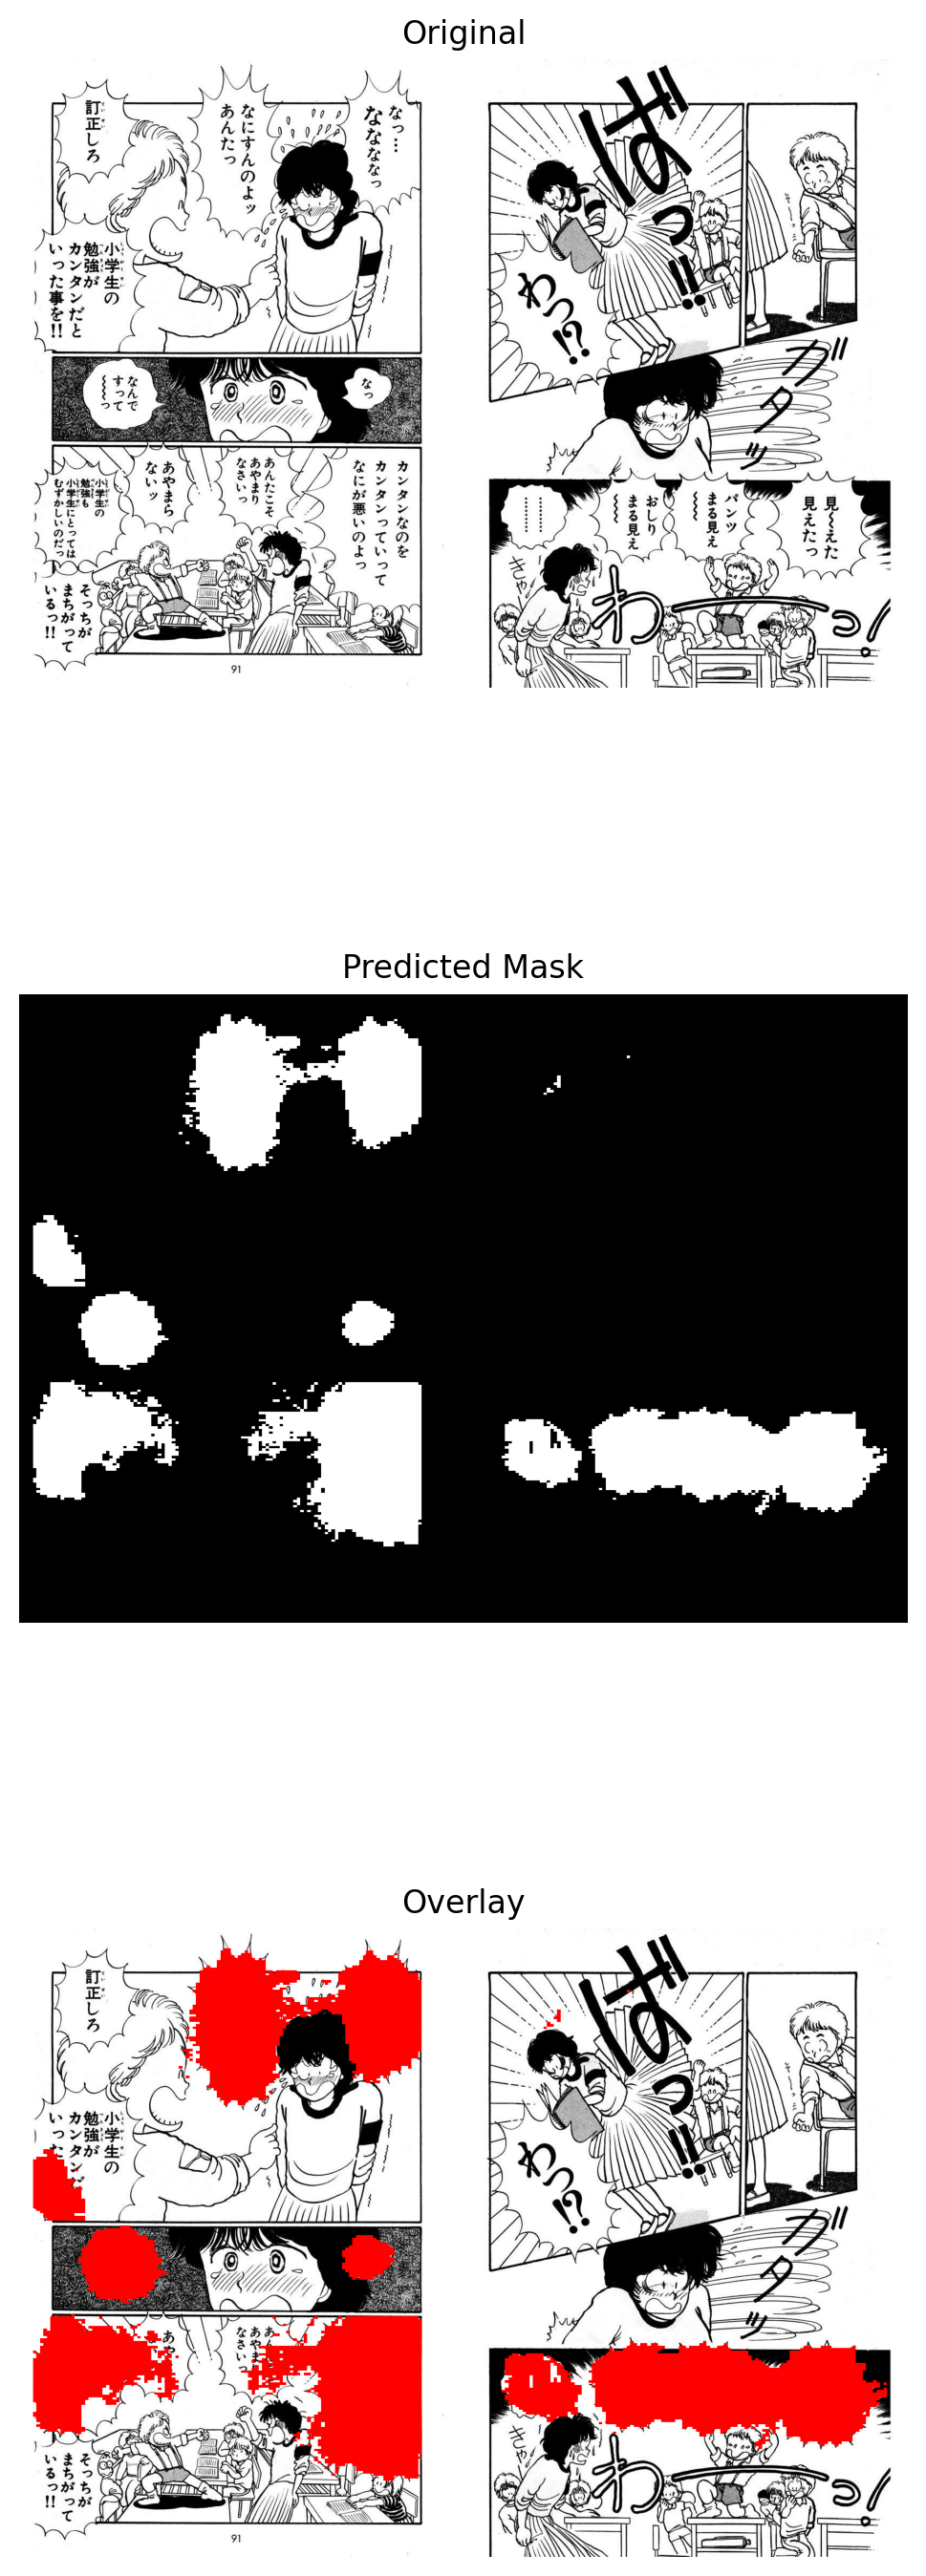

In [6]:

state_dict = torch.load(UNET_MODEL_FILE, 
                        map_location=torch.device(device))

if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    state_dict = new_state_dict

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(state_dict, strict=False)
model.eval()


img = cv2.imread(EX_IMG_FILE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

resized = cv2.resize(img, (256, 256)) 

transform = T.Compose([
    T.ToTensor(),
])

input_tensor = transform(resized).unsqueeze(0)

with torch.no_grad():
    pred = model(input_tensor)
    pred = torch.sigmoid(pred)
    pred = pred.squeeze().cpu().numpy()

mask = (pred > 0.5).astype(np.uint8)

mask_full = cv2.resize(mask, (img.shape[1], img.shape[0]))

overlay = img.copy()
overlay[mask_full == 1] = (255, 0, 0)  # đánh dấu màu đỏ

plt.figure(figsize=(6,18), dpi=200)
plt.subplot(3,1,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("Predicted Mask")
plt.imshow(mask_full, cmap="gray")
plt.axis("off")

plt.subplot(3,1,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.savefig("inference.png")
plt.show()
